# HOME CREDIT DEFAULT RISK PROJECT

# Project Aim:
 Building a model to find out how capable each loan applicant is of repaying a loan,
 so that approving loans only for the applicants who are likely to repay the loan.

# Data Description and Overview:

There are 7 different sources of data:
1. application_train/application_test: The main training data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
2. bureau: In this dataset it consists of data concerning client’s previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
3. bureau_balance: It consists of monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
4. previous_application:The data of previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified.
5. POS_CASH_BALANCE: It consists of monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
6. credit_card_balance:The monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
7. installments_payment:The data of payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.
https://medium.com/@praveenkotha/home-credit-default-risk-end-to-end-machine-learning-project-1871f52e3ef2


# Project Outline
1. Exploratory Data Analysis: This section includes performing initial investigations on data so as to discover patterns with the help of summary statistics and graphical representations. 
2. Feature Generation and Elimination: This section includes generating features using the main data source and combining other supplementary sources provided, after investigation and understanding the data. This step is applied on both train and test sets. 
3. Model Application: This section includes applying a machine learning algortihm on the final train set to predict test set labels.

# 1.Exploratory Data Analysis:


Importing Libraries

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import pickle
import gc
from plotly import tools

warnings.filterwarnings('ignore')
%matplotlib inline

Importing Data: Reading all 7 files into python

In [2]:
directory = 'C:\\CreditRiskProject\\Datasets'
train_set = pd.read_csv(directory+ '\\application_train.csv')
test_set = pd.read_csv(directory+ '\\application_test.csv')
bureau = pd.read_csv(directory+ '\\bureau.csv')
pos_cash = pd.read_csv(directory+ '\\POS_CASH_balance.csv')
previous_applicaton = pd.read_csv(directory+ '\\previous_application.csv')
credit_card_balance = pd.read_csv(directory+ '\\credit_card_balance.csv')
installments_payments = pd.read_csv(directory+ '\\installments_payments.csv')

We can see how the main dataset looks like

In [3]:
train_set.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We can check the statistical values of numeric colums. Although 'SK_ID_CURR' and 'TARGET' are numeric colums, we should not include them as SK_ID_CURR is the unique id and TARGET is the binary classification label. 

In [19]:
numerics = train_set._get_numeric_data()
numerics = numerics.drop(columns=['SK_ID_CURR', 'TARGET'])
numerics.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


We can see the ratio of null values for each column. Columns having more null values than the threshold shoud be checked before starting the model. Since these features might be misleading to the model, we can consider removing them later on.

In [20]:
Desc = train_set.describe().transpose().reset_index()
Desc = Desc.rename(columns = {"index":"Features"})
Desc["NullCount"] = 0
Desc["NullRatio"] = 0
for i in train_set.columns:
    Null = train_set[i].isna().sum()
    Ratio = float((train_set[i].isna().sum())) / float(len(train_set))
    Desc.loc[Desc['Features'] == i, ["NullCount"]] = Null
    Desc.loc[Desc['Features'] == i, ["NullRatio"]] = Ratio
    
NullsTable = Desc[['Features', 'count','NullCount', 'NullRatio']].sort_values(by =['NullRatio'],ascending=False)
NullsTable.head(10)

,Features,count,NullCount,NullRatio
50,COMMONAREA_MODE,92646.0,214865,0.698723
36,COMMONAREA_AVG,92646.0,214865,0.698723
64,COMMONAREA_MEDI,92646.0,214865,0.698723
44,NONLIVINGAPARTMENTS_AVG,93997.0,213514,0.694330
58,NONLIVINGAPARTMENTS_MODE,93997.0,213514,0.694330
72,NONLIVINGAPARTMENTS_MEDI,93997.0,213514,0.694330
56,LIVINGAPARTMENTS_MODE,97312.0,210199,0.683550
42,LIVINGAPARTMENTS_AVG,97312.0,210199,0.683550
70,LIVINGAPARTMENTS_MEDI,97312.0,210199,0.683550
68,FLOORSMIN_MEDI,98869.0,208642,0.678486


As we can see, many columns have high ratio of missing values. We should not use these columns having null values over 10% for our model, and deal with the null values of other columns with less than 10%.

# Distribution Of Data Among Positive and Negative Classes
We should check whether the train dataset is balanced or imbalanced.

In [4]:
train_set_Target1 = train_set[train_set['TARGET'] == 1]
train_set_Target0 = train_set[train_set['TARGET'] == 0]

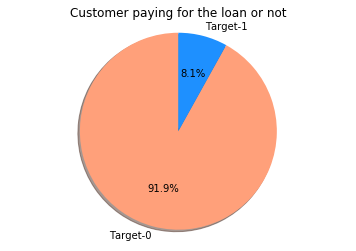

In [5]:
temp = train_set["TARGET"].value_counts()
temp2 = pd.DataFrame({'labels': ["Target-0","Target-1"],
                   'values': temp.values
                  })
colors = ['lightsalmon', 'dodgerblue']
plt.pie(temp2["values"], labels=temp2["labels"], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Customer paying for the loan or not")

plt.axis('equal')
plt.show()

As we can see, the dataset is imbalanced. Positive class ratio is only 0.081. We can also see the number of customers in each label.

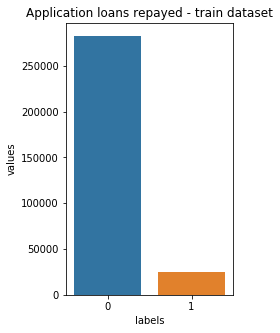

In [6]:
temp = train_set["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (3,5))
plt.title('Application loans repayed - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

Since it is an imbalanced we shoud check some of the features distributions for each class. Distributions or ratios might be similar or might show different behaviors for each class.

# Distribution of credit amount of the loan for positive and negative classes

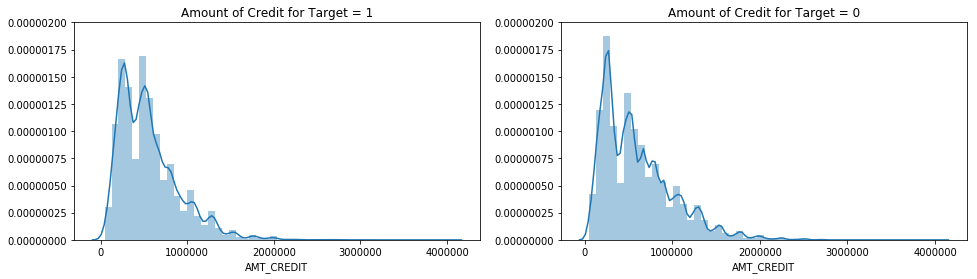

In [11]:
fig, axs = plt.subplots(1,2, figsize=(16, 4))
axs[0].set_ylim([0, 0.000002])
axs[1].set_ylim([0, 0.000002])
ax = sns.distplot(train_set_Target1["AMT_CREDIT"].dropna(),ax=axs[0]).set_title("Amount of Credit for Target = 1")
ay = sns.distplot(train_set_Target0["AMT_CREDIT"].dropna(),ax=axs[1]).set_title("Amount of Credit for Target = 0")

Credit amount of the loan shows similar behaviors for both classes, both are right skewed. Most of the credit amounts are less than 1,000,000. The average amount of credit is higher for negative class (mean = 602648) than the positive class (mean = 557779).

# Distribution of goods price for given loan for positive and negative classes

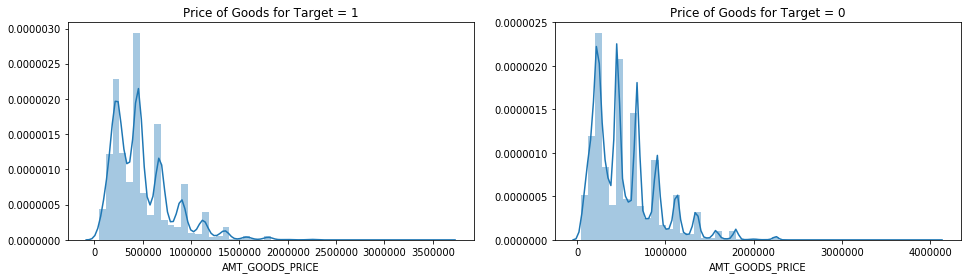

In [21]:
fig, axs = plt.subplots(1,2, figsize=(16, 4))

ax = sns.distplot(train_set_Target1["AMT_GOODS_PRICE"].dropna(),ax=axs[0]).set_title("Price of Goods for Target = 1")
ay = sns.distplot(train_set_Target0["AMT_GOODS_PRICE"].dropna(),ax=axs[1]).set_title("Price of Goods for Target = 0")

Price of the goods for which the loan is given shows similar behaviors, both are right skewed. Most of the price of the goods are less than 1,500,000. The average price of the goods credit is higher for negative class (mean = 542737) than the positive class (mean = 488972).

# Distribution of loan annuity for positive and negative classes

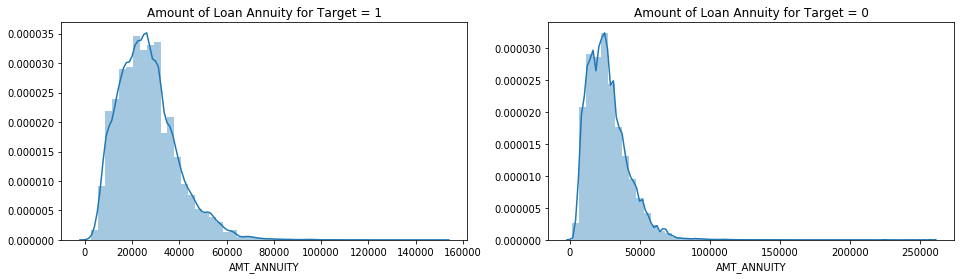

In [23]:
fig, axs = plt.subplots(1,2, figsize=(16, 4))

ax = sns.distplot(train_set_Target1["AMT_ANNUITY"].dropna(),ax=axs[0]).set_title("Amount of Loan Annuity for Target = 1")
ay = sns.distplot(train_set_Target0["AMT_ANNUITY"].dropna(),ax=axs[1]).set_title("Amount of Loan Annuity for Target = 0")

We can see that amount of annuity for the loan also shows similar behaviors for positive and negative classes. 

# Number of enquiries to Credit Bureau about the client in a year

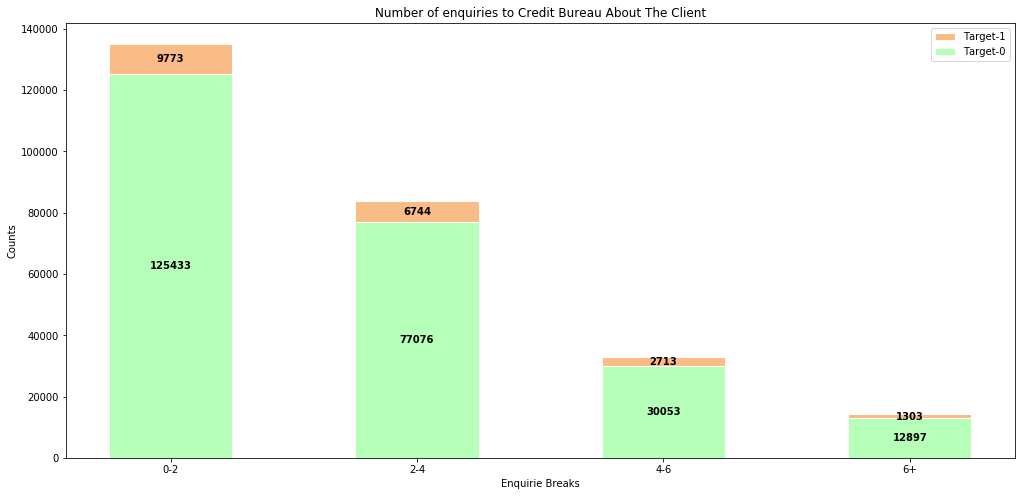

In [26]:
Df_count = train_set.groupby(['TARGET', 'AMT_REQ_CREDIT_BUREAU_YEAR']).size().reset_index(name='counts')
train_set_0 = Df_count[Df_count['TARGET'] == 0]
train_set_1 = Df_count[Df_count['TARGET'] == 1]

list_0 = []
list_1 = []
for i in [2,4,6,50]:
    c0 = train_set_0.loc[(train_set_0['AMT_REQ_CREDIT_BUREAU_YEAR'] < i), 'counts'].sum()
    c1 = train_set_1.loc[(train_set_1['AMT_REQ_CREDIT_BUREAU_YEAR'] < i), 'counts'].sum()
    list_0.append(c0)
    list_1.append(c1)
list_0[1:len(list_0)] = [j-i for i, j in zip(list_0[:-1], list_0[1:])]
list_1[1:len(list_1)] = [j-i for i, j in zip(list_1[:-1], list_1[1:])]

plt.figure(figsize=(17,8))
r = [0,1,2,3]
barWidth = 0.5
names = ('0-2','2-4','4-6','6+')
# Create green Bars
p0 = plt.bar(r, list_0, color='#b5ffb9', edgecolor='white', width=barWidth)
p1 = plt.bar(r, list_1, bottom=list_0, color='#f9bc86', edgecolor='white', width=barWidth)
plt.xticks(r, names)
plt.legend((p1[0], p0[0]), ('Target-1', 'Target-0'))
plt.title('Number of enquiries to Credit Bureau About The Client')
plt.xlabel('Enquirie Breaks')
plt.ylabel('Counts')

for r1, r2 in zip(p0, p1):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="center", color="black", fontsize=10, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="center", color="black", fontsize=10, fontweight="bold")

plt.show()

There is a large number of customers having enquiries to Credit Bureau between 0-2. As the number of enquiries to Credit Bureau increases, number of occurance decreases in both classes. Number of enquiries is much greater for Target-0 than Target-1.

# Positive and Negative class ratios for men and women

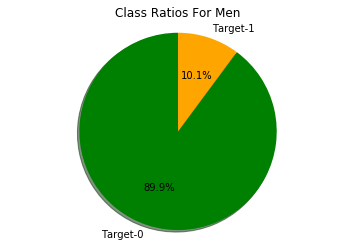

In [35]:
CashLoans = train_set[train_set.CODE_GENDER == 'M']
temp = CashLoans["TARGET"].value_counts()
df = pd.DataFrame({'labels': ["Target-0","Target-1"],
                   'values': temp.values
                  })
colors = ['green', 'orange']
plt.pie(df["values"], labels=df["labels"], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Class Ratios For Men")

plt.axis('equal')
plt.show()

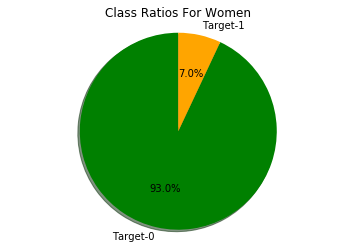

In [36]:
CashLoans = train_set[train_set.CODE_GENDER == 'F']
temp = CashLoans["TARGET"].value_counts()
df = pd.DataFrame({'labels': ["Target-0","Target-1"],
                   'values': temp.values
                  })
colors = ['green', 'orange']
plt.pie(df["values"], labels=df["labels"], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Class Ratios For Women")

plt.axis('equal')
plt.show()

Positive class ratio is higher among men than women.

# Categorical Distributions :
    1. Family Status
    2. Contract Type
    3. Education
    4. Occupation

# Distribution of Family Status

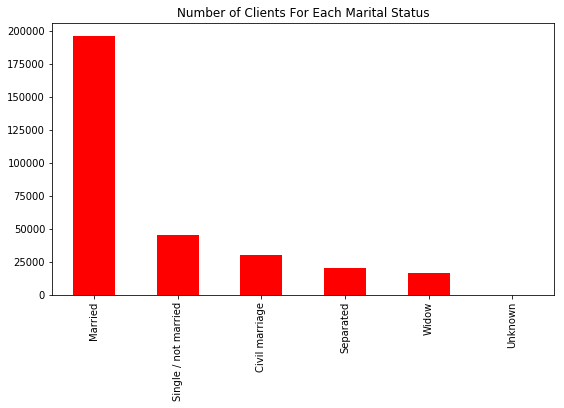

In [16]:
fms = train_set['NAME_FAMILY_STATUS'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Number of Clients For Each Marital Status", color= 'red')

Mostly married people have applied for a larger number of loan applications around 200K,followed by Single/not married and civil marriage.

# Distribution of Contract Type

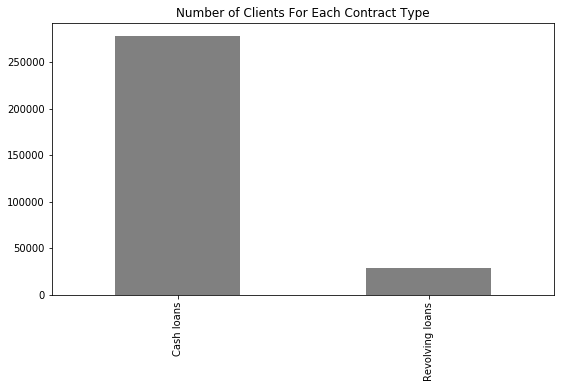

In [4]:
loantyp = train_set['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Number of Clients For Each Contract Type", color= 'gray')

Majority ofthe clients are applying for cash loan.

# Distribution of Education Type

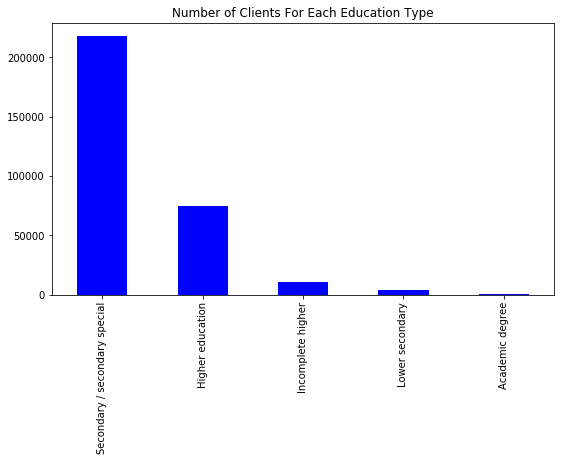

In [24]:
edctyp = train_set['NAME_EDUCATION_TYPE'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Number of Clients For Each Education Type", color= 'blue')

The number of people applying for a loan among highly educated people is lower. Macority of applicants belong to secondary education type.

# Distribution of Occupation Type

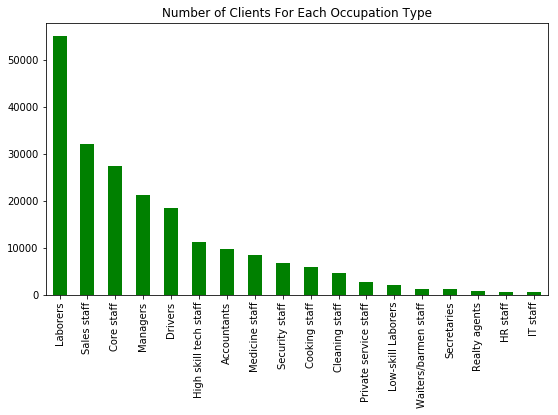

In [5]:
ocptyp = train_set['OCCUPATION_TYPE'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Number of Clients For Each Occupation Type", color= 'green')

Most of the loans are taken by Laborers, followed by Sales staff and core staff. IT staff take the lowest amount of loans.

.

# 2. Feature Generation

# Feature Generation For Train Set

There is one main data source (application_train.csv), including information about each loan application with a unique loan id. It has information about the clients such as clients' gender, if s/he owns a house, number of children the client has, income of the client, scores from each client from external sources and, credit amount and loan annuity of the loan that the client applies for. From the provided columns, we can extract other colums such as; a flag showing if a customer has greater income than the credit he applies, the ratio of the credit amount over the income amount of the client, the ratio of the annuity amount over the income amount of the client, the ratio of the credit amount over the annuity amount, the ratio of the days s/he's employed in his life, and with which ratio of the amount of the goods price, he uses credit. We can add these futures to the main dataset. The code to attach these futures is shown below.

In [24]:
#Feature Generation From Application Data (main data source):
#If a customer has greater income than the credit he applies
train_set['INCOME_GT_CREDIT_FLAG'] = np.where(train_set['AMT_INCOME_TOTAL'] > train_set['AMT_CREDIT'], 1, 0)  #takes 1 if income is greater, 0 o/w

#Credit Income Ratio
train_set['CREDIT_INCOME_PERCENT'] = train_set['AMT_CREDIT'] / train_set['AMT_INCOME_TOTAL']

#Annuity Income Ratio
train_set['ANNUITY_INCOME_PERCENT'] = train_set['AMT_ANNUITY'] / train_set['AMT_INCOME_TOTAL']

# Column to represent Credit Term
train_set['CREDIT_TERM'] = train_set['AMT_CREDIT'] / train_set['AMT_ANNUITY']

# Column to represent Days Employed percent in his life
train_set['DAYS_EMPLOYED_PERCENT'] = train_set['DAYS_EMPLOYED'] / train_set['DAYS_BIRTH']

#Credit-Price of Goods Ratio
train_set['CREDIT_PRICE_OF_GOODS_RATIO'] = train_set['AMT_CREDIT'] / train_set['AMT_GOODS_PRICE']

There are other supplementary datasets that we can combine to the main dataset and generate other futures. Each supplementary dataset has information about the unique loan id, but multiple instances for a single loan id. Once we group the data by the unique loan id and merge it to the train set; we can have information about the client's previous behaviors and oher actions related to the loan. The code of how to use each supplementary data source and what features to add from it is shown below with illustrative comments.

In [25]:
#Feature Generation From Other Data (other data sources):
##----------------------------------------------------------------------------------------------------------------
#---------Combining Breau Data to Train set----
#group data by id: We can extract number of previous credit, number of active credit, total credit, total debt and total limit for each customer
bureau['CREDIT_ACTIVE_FLAG'] = np.where(bureau['CREDIT_ACTIVE'] == 'Active', 1, 0) #takes 1 if credit is active, 0 o/w
BreauSumTable = bureau[['SK_ID_CURR','CREDIT_ACTIVE_FLAG','AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT']].groupby(['SK_ID_CURR']).sum().reset_index()
BreauSumTable = BreauSumTable.rename(columns={'CREDIT_ACTIVE_FLAG':'NUMBER_OF_ACTIVE_CREDIT_BUREAU','AMT_CREDIT_SUM':'TOTAL_CUSTOMER_CREDIT_BUREAU','AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT_BUREAU', 'AMT_CREDIT_SUM_LIMIT':'TOTAL_CUSTOMER_LIMIT_BUREAU'})

BreauCountTable = bureau[['SK_ID_CURR','SK_ID_BUREAU']].groupby(['SK_ID_CURR']).count().reset_index()
BreauCountTable = BreauCountTable.rename(columns={'SK_ID_BUREAU':'NUMBER_OF_PREVIOUS_CREDIT_BUREAU'})

#merge groupped data into train set:
train_set =  train_set.merge(BreauSumTable, on='SK_ID_CURR', how='left')
train_set =  train_set.merge(BreauCountTable, on='SK_ID_CURR', how='left')

#fill ne values with zero
train_set.update(train_set[BreauSumTable.columns].fillna(0))
train_set.update(train_set[BreauCountTable.columns].fillna(0))
#train_set.head()


##----------------------------------------------------------------------------------------------------------------
#---------Combining pos_cash Data to Train set----
#group data by id: We can extract number of previous credit, number of active credit, and average of installments for each customer
pos_cash['ACTIVE_STATUS'] = np.where(pos_cash['NAME_CONTRACT_STATUS'] == 'Active', 1, 0) #takes 1 if  active, 0 o/w
pos_cashSum = pos_cash[['SK_ID_CURR','ACTIVE_STATUS']].groupby(['SK_ID_CURR']).sum().reset_index()
pos_cashSum = pos_cashSum.rename(columns={'ACTIVE_STATUS':'NUMBER_OF_ACTIVE_CONTRACT_CASH'})

pos_cashCount = pos_cash[['SK_ID_CURR','SK_ID_PREV']].groupby(['SK_ID_CURR']).count().reset_index()
pos_cashCount = pos_cashCount.rename(columns={'SK_ID_PREV':'NUMBER_OF_PREVIOUS_CREDIT_CASH'})

pos_cashAvg = pos_cash[['SK_ID_CURR','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE']].groupby(['SK_ID_CURR']).mean().reset_index()
pos_cashAvg = pos_cashAvg .rename(columns={'CNT_INSTALMENT':'AVG_OF_INSTALLMENTS_CASH', 'CNT_INSTALMENT_FUTURE':'AVG_OF_INSTALLMENTS_LEFT_CASH'})

#merge groupped data into train set:
train_set =  train_set.merge(pos_cashCount, on='SK_ID_CURR', how='left')
train_set =  train_set.merge(pos_cashSum, on='SK_ID_CURR', how='left')
train_set =  train_set.merge(pos_cashAvg, on='SK_ID_CURR', how='left')

#fill ne values with zero
train_set.update(train_set[pos_cashCount.columns].fillna(0))
train_set.update(train_set[pos_cashSum.columns].fillna(0))
train_set.update(train_set[pos_cashAvg.columns].fillna(0))
#train_set.head()


##----------------------------------------------------------------------------------------------------------------
#---------Combining credit_card_balance Data to Train set----

#group data by id: We can extract number of avtive card contracts, number of previous credit card,
#//total balance, total limit, total drawings amounts and count of drawings of each customer
credit_card_balance['ACTIVE_STATUS'] = np.where(credit_card_balance['NAME_CONTRACT_STATUS'] == 'Active', 1, 0) #takes 1 if  active, 0 o/w
credit_card_balanceSum = credit_card_balance[['SK_ID_CURR','ACTIVE_STATUS']].groupby(['SK_ID_CURR']).sum().reset_index()
credit_card_balanceSum = credit_card_balanceSum.rename(columns={'ACTIVE_STATUS':'NUMBER_OF_ACTIVE_CONTRACT_CARD'})

credit_card_balanceCount = credit_card_balance[['SK_ID_CURR','SK_ID_PREV']].groupby(['SK_ID_CURR']).count().reset_index()
credit_card_balanceCount = credit_card_balanceCount.rename(columns={'SK_ID_PREV':'NUMBER_OF_PREVIOUS_CARD'})

credit_card_balanceTotal = credit_card_balance[['SK_ID_CURR','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_DRAWINGS_CURRENT','CNT_DRAWINGS_CURRENT' ]].groupby(['SK_ID_CURR']).sum().reset_index()
credit_card_balanceTotal = credit_card_balanceTotal .rename(columns={'AMT_BALANCE':'TOTAL_AMOUNT_BALANCE_CARD', 'AMT_CREDIT_LIMIT_ACTUAL':'TOTAL_LIMIT_CARD', 'AMT_DRAWINGS_CURRENT':'TOTAL_DRAVINGS_CARD', 'CNT_DRAWINGS_CURRENT':'COUNT_OF_DRAVINGS_CARD'})

#merge groupped data into train set:
train_set =  train_set.merge(credit_card_balanceSum, on='SK_ID_CURR', how='left')
train_set =  train_set.merge(credit_card_balanceCount, on='SK_ID_CURR', how='left')
train_set =  train_set.merge(credit_card_balanceTotal, on='SK_ID_CURR', how='left')

#fill ne values with zero
train_set.update(train_set[pos_cashCount.columns].fillna(0))
train_set.update(train_set[pos_cashSum.columns].fillna(0))
train_set.update(train_set[pos_cashAvg.columns].fillna(0))
#train_set.head()


##----------------------------------------------------------------------------------------------------------------
#----------Combining previous_applicaton Data to Train set

#group data by id: We can extract count of previous application, count of approved apllications
#//total annuity, total application, total credit of each customer
previous_applicaton['ACTIVE_STATUS'] = np.where(previous_applicaton['NAME_CONTRACT_STATUS'] == 'Approved', 1, 0) #takes 1 if  active, 0 o/w
previous_applicatonSum = previous_applicaton[['SK_ID_CURR','ACTIVE_STATUS']].groupby(['SK_ID_CURR']).sum().reset_index()
previous_applicatonSum = previous_applicatonSum.rename(columns={'ACTIVE_STATUS':'COUNT_OF_APPROVED_APPLS'})

previous_applicatonCount = previous_applicaton[['SK_ID_CURR','SK_ID_PREV']].groupby(['SK_ID_CURR']).count().reset_index()
previous_applicatonCount = previous_applicatonCount.rename(columns={'SK_ID_PREV':'NUMBER_OF_PREVIOUS_APPLS'})

previous_applicatonTotal = previous_applicaton[['SK_ID_CURR','AMT_ANNUITY', 'AMT_APPLICATION','AMT_CREDIT']].groupby(['SK_ID_CURR']).sum().reset_index()
previous_applicatonTotal = previous_applicatonTotal .rename(columns={'AMT_ANNUITY':'TOTAL_ANNUITY_APPLS', 'AMT_APPLICATION':'TOTAL_APPLS', 'AMT_CREDIT':'TOTAL_CREDIT_APPLS'})

#merge groupped data into train set:
train_set =  train_set.merge(previous_applicatonSum, on='SK_ID_CURR', how='left')
train_set =  train_set.merge(previous_applicatonCount, on='SK_ID_CURR', how='left')
train_set =  train_set.merge(previous_applicatonTotal, on='SK_ID_CURR', how='left')

#fill ne values with zero
train_set.update(train_set[previous_applicatonCount.columns].fillna(0))
train_set.update(train_set[previous_applicatonSum.columns].fillna(0))
train_set.update(train_set[previous_applicatonTotal.columns].fillna(0))
#train_set.head()


##----------------------------------------------------------------------------------------------------------------
#----------Combining installments_payments Data to Train set

#group data by id: We can extract average number of installments that each customer makes payment
installments_paymentsAvg = installments_payments[['SK_ID_CURR','NUM_INSTALMENT_NUMBER']].groupby(['SK_ID_CURR']).mean().reset_index()
installments_paymentsAvg = installments_paymentsAvg.rename(columns={'NUM_INSTALMENT_NUMBER':'AVERAGE_OF_INSTALLMENT_PAYMENT'})

#merge groupped data into train set:
train_set =  train_set.merge(installments_paymentsAvg, on='SK_ID_CURR', how='left')

#fill ne values with zero
train_set.update(train_set[installments_paymentsAvg.columns].fillna(0))

Some colums have a considerable amount of missing values which can be misleading for the predicitions of the model on the test set. Due to this reason, I decided to remove colums having more than 10% of null values in it. After composing our final train data set by adding an removing features, we can write this data frame into a csv file for further use.

In [26]:
#----------Feature Elimination:

#Removing Columns Having Null Valio of ratio more than 0.1
def rmissingvaluecol(dff,threshold):
    l = []
    l = list(dff.drop(dff.loc[:,list((100*(dff.isnull().sum()/len(dff.index))>=threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values:"%threshold,(dff.shape[1] - len(l)))
    print("Columns:\n",list(set(list((dff.columns.values))) - set(l)))
    return l


remaningColums= rmissingvaluecol(train_set,10) #Here threshold is 10% which means we are going to drop columns having more than 10% of missing values
train_set2 = train_set[remaningColums]

train_set2.to_csv(directory+ '\\train_set_final.csv')

# Columns having more than 10 percent missing values: 63
Columns:
 ['COMMONAREA_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'HOUSETYPE_MODE', 'OCCUPATION_TYPE', 'FLOORSMAX_MODE', 'ELEVATORS_AVG', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'COUNT_OF_DRAVINGS_CARD', 'LIVINGAPARTMENTS_MODE', 'APARTMENTS_AVG', 'TOTALAREA_MODE', 'OWN_CAR_AGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLOORSMIN_MEDI', 'COMMONAREA_AVG', 'NUMBER_OF_ACTIVE_CONTRACT_CARD', 'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'COMMONAREA_MODE', 'YEARS_BUILD_MEDI', 'FLOORSMAX_AVG', 'LIVINGAPARTMENTS_AVG', 'ELEVATORS_MODE', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MODE', 'ELEVATORS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'ENTRANCES_AVG', 'FLOORSMAX_MEDI', 'NONLIVINGAREA_MEDI', 'EXT_SOURCE_1', 'NUMBER_OF_PREVIOUS_CARD', 'AMT_REQ_CREDIT_BUREAU_DAY', 'NONLIVINGAREA_AVG', 'BASEMENTAREA_AVG', 'LIVINGAREA_MODE', 'WALLSMATERIAL_MODE'

# Feature Generation For Test Set

We should follow the same steps as we did for train set, on the test set as well, so we can use the test set for making predictions. Test set does not have the TARGET feature.

In [27]:
###------------Test Set Preparation (with the columns from test set):

test_set['INCOME_GT_CREDIT_FLAG'] = np.where(test_set['AMT_INCOME_TOTAL'] > test_set['AMT_CREDIT'], 1, 0)  #takes 1 if income is greater, 0 o/w

#Credit Income Ratio
test_set['CREDIT_INCOME_PERCENT'] = test_set['AMT_CREDIT'] / test_set['AMT_INCOME_TOTAL']

#Annuity Income Ratio
test_set['ANNUITY_INCOME_PERCENT'] = test_set['AMT_ANNUITY'] / test_set['AMT_INCOME_TOTAL']

# Column to represent Credit Term
test_set['CREDIT_TERM'] = test_set['AMT_CREDIT'] / test_set['AMT_ANNUITY']

# Column to represent Days Employed percent in his life
test_set['DAYS_EMPLOYED_PERCENT'] = test_set['DAYS_EMPLOYED'] / test_set['DAYS_BIRTH']

#Credit-Price of Goods Ratio
test_set['CREDIT_PRICE_OF_GOODS_RATIO'] = test_set['AMT_CREDIT'] / test_set['AMT_GOODS_PRICE']

##--------------------------
#merge groupped data into train set:
test_set =  test_set.merge(BreauSumTable, on='SK_ID_CURR', how='left')
test_set =  test_set.merge(BreauCountTable, on='SK_ID_CURR', how='left')

#fill ne values with zero
test_set.update(test_set[BreauSumTable.columns].fillna(0))
test_set.update(test_set[BreauCountTable.columns].fillna(0))
#test_set.head()

#merge groupped data into train set:
test_set =  test_set.merge(pos_cashCount, on='SK_ID_CURR', how='left')
test_set =  test_set.merge(pos_cashSum, on='SK_ID_CURR', how='left')
test_set =  test_set.merge(pos_cashAvg, on='SK_ID_CURR', how='left')

#fill ne values with zero
test_set.update(test_set[pos_cashCount.columns].fillna(0))
test_set.update(test_set[pos_cashSum.columns].fillna(0))
test_set.update(test_set[pos_cashAvg.columns].fillna(0))
#test_set.head()

#merge groupped data into train set:
test_set =  test_set.merge(credit_card_balanceSum, on='SK_ID_CURR', how='left')
test_set =  test_set.merge(credit_card_balanceCount, on='SK_ID_CURR', how='left')
test_set =  test_set.merge(credit_card_balanceTotal, on='SK_ID_CURR', how='left')

#fill ne values with zero
test_set.update(test_set[pos_cashCount.columns].fillna(0))
test_set.update(test_set[pos_cashSum.columns].fillna(0))
test_set.update(test_set[pos_cashAvg.columns].fillna(0))
#test_set.head()

#merge groupped data into train set:
test_set =  test_set.merge(previous_applicatonSum, on='SK_ID_CURR', how='left')
test_set =  test_set.merge(previous_applicatonCount, on='SK_ID_CURR', how='left')
test_set =  test_set.merge(previous_applicatonTotal, on='SK_ID_CURR', how='left')

#fill ne values with zero
test_set.update(test_set[previous_applicatonCount.columns].fillna(0))
test_set.update(test_set[previous_applicatonSum.columns].fillna(0))
test_set.update(test_set[previous_applicatonTotal.columns].fillna(0))
#test_set.head()

#merge groupped data into train set:
test_set =  test_set.merge(installments_paymentsAvg, on='SK_ID_CURR', how='left')

#fill ne values with zero
test_set.update(test_set[installments_paymentsAvg.columns].fillna(0))


#Removes TARGET from remaining colums
del remaningColums[1]
test_set2 = test_set[remaningColums]
test_set2.to_csv(directory+ '\\test_set_final.csv')

# 3. Model Application

Home Credit Default Risk Project is a binary classificaiton problem. However making binary predictions for the target will not be meaningful. We should use probabilities instead, to score the clients according to how capable they are to repay the loan.For example, we should not classify two clients having scores 0.75 and 0.9 as positive just because they both have greater score than 0.5. We should consider the client with score 0.9 has higher probablity on positive class than the client with score 0.75.

Since it is a long-term predictions problem, the algorithm can take some time to run. That is the reason why we can use ensemble methods. 

We can use Area under Curve to summarize the model performance, as it is the most expressive way. We can plot the ROC curve,  to visualize the performance of a binary classifier.

# Validation of the model using only train set and splitting it into two sets:

We have a train set with 307511 rows and 86 features. As train set and test sets for this project are split on the loan id, we can split the train set into smaller train and test sets for the application of the model and to see the model preformance.

In this section, I split train data into two. I prepared both sets for the catboost algoritm. I fitted the model on the 80% of the data, and predict the targets for the remaining 20%. I used 5 folds for cross validaiton and made 500 itearions with early stopping 25. I used AUC as a measurement of the model performance and plotted ROC curve to visualize.

In [35]:
import pandas as pd
import catboost as cat
from sklearn.preprocessing import LabelEncoder
import os
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt


directory = 'C:\\CreditRiskProject\\Datasets'
train_set = pd.read_csv(directory+ '\\train_set_final.csv', index_col=0)

In [38]:
train_set.shape

(307511, 86)

In [39]:
train_set.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,NUMBER_OF_PREVIOUS_CREDIT_CASH,NUMBER_OF_ACTIVE_CONTRACT_CASH,AVG_OF_INSTALLMENTS_CASH,AVG_OF_INSTALLMENTS_LEFT_CASH,COUNT_OF_APPROVED_APPLS,NUMBER_OF_PREVIOUS_APPLS,TOTAL_ANNUITY_APPLS,TOTAL_APPLS,TOTAL_CREDIT_APPLS,AVERAGE_OF_INSTALLMENT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,19.0,19.0,24.000000,15.000000,1.0,1.0,9251.775,179055.00,179055.0,10.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,28.0,26.0,10.107143,5.785714,3.0,3.0,169661.970,1306309.50,1452573.0,5.080000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,4.0,3.0,3.750000,2.250000,1.0,1.0,5357.250,24282.00,20106.0,2.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,21.0,18.0,12.000000,8.650000,5.0,9.0,141907.050,2449829.34,2625259.5,4.437500
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,66.0,62.0,15.333333,8.969697,6.0,6.0,73672.830,903181.50,999832.5,7.045455


As we can see from the table above, in this data set, there are categorical values that we should encode to fit the model. Then we can apply CatBoost algorithm and measure the performance by AUC and see the feature importances. The code is provided below with illustrative comments.

In [40]:
#Remove Unnecessary colums
def removenonuniquecol(dataset):
    dropcols = [col for col in dataset.columns if dataset[col].nunique(dropna=True)==1]
    print ('Removing columns: ',dropcols)
    dataset.drop(dropcols,axis= 1,inplace= True,errors= 'ignore')
    return dropcols

#For label encoding
def labelencoder(dataset):
    objectlist = dataset.select_dtypes(include=['object']).copy()
    cat_col = [col for col in dataset.columns if col in objectlist]
    for col in cat_col:
        print("Encoding ",col)
        lbl = LabelEncoder()
        dataset[col].fillna(-999)
        lbl.fit(list(dataset[col].values.astype('str')))
        dataset[col] = lbl.transform(list(dataset[col].values.astype('str')))
    return cat_col

#######################Trainset preperation#####################################################

def TrainPrep(Datasetname):
    removedCols = removenonuniquecol(Datasetname)
    Predictors = [col for col in Datasetname]
    Predictors = [col for col in Predictors if col not in removedCols]
    Predictors = [col for col in Predictors if col not in ['TARGET']]
    DfLabel = Datasetname['TARGET']
    encodedList = labelencoder(Datasetname)
    return Predictors,Datasetname, DfLabel, removedCols, encodedList

Predictors,Df_1, Label_1, removedCols, encodedList = TrainPrep(train_set)

X_train, X_test, y_train, y_test = train_test_split(Df_1, Label_1, stratify=Df_1['TARGET'], test_size=0.2)


#####################Training Classifier############################################################################


def catboosttrainer(X,y,features,initparam,modelname,modelpath,docpath,cvfold = 5):
    print ("searching for optimal iteration count...")
    trainpool = cat.Pool(X[features],y)
    cvresult = cat.cv(params= initparam, fold_count=cvfold, pool=trainpool,stratified = True)
    initparam['iterations'] = (len(cvresult)) - (initparam['od_wait']+1)   
    del initparam['od_wait'] 
    del initparam['od_type']
    print ("optimal iteration count is ", initparam['iterations'])
    print ("fitting model...")
    clf = cat.CatBoostClassifier(** initparam)
    clf.fit(trainpool)
    imp = clf.get_feature_importance(trainpool,fstr_type='FeatureImportance')
    dfimp = pd.DataFrame(imp,columns = ['CatBoostImportance'])
    dfimp.insert(0,column='Feature', value=features) 
    dfimp = dfimp.sort_values(['CatBoostImportance','Feature'], ascending= False)
    xlsxpath = os.path.join(docpath,modelname+".xlsx")
    dfimp.to_excel(xlsxpath)
    print ("pickling model...")
    picklepath = os.path.join(modelpath,modelname)
    with open(picklepath,'wb') as fout:
        pickle.dump(clf, fout)
    return cvresult,clf,initparam,dfimp



modelpath = 'C:\\CreditRiskProject'
docpath = 'C:\\CreditRiskProject'
CatBoostParam = { 'iterations': 500, 'od_type': 'Iter', 'od_wait': 25,'loss_function': 'Logloss','eval_metric': 'AUC', "random_seed" : 123}

cvresult,clf,initparam,dfimp = catboosttrainer(X_train,y_train,Predictors,CatBoostParam,'CBmodel',modelpath,docpath,cvfold = 5)

proba = clf.predict_proba(X_test[Predictors])[:,1]
auc = roc_auc_score(y_test,proba)
print(auc)



Removing columns:  []
Encoding  NAME_CONTRACT_TYPE
Encoding  CODE_GENDER
Encoding  FLAG_OWN_CAR
Encoding  FLAG_OWN_REALTY
Encoding  NAME_TYPE_SUITE
Encoding  NAME_INCOME_TYPE
Encoding  NAME_EDUCATION_TYPE
Encoding  NAME_FAMILY_STATUS
Encoding  NAME_HOUSING_TYPE
Encoding  WEEKDAY_APPR_PROCESS_START
Encoding  ORGANIZATION_TYPE
searching for optimal iteration count...
0:	test: 0.6002952	best: 0.6002952 (0)
1:	test: 0.6478499	best: 0.6478499 (1)
2:	test: 0.6599599	best: 0.6599599 (2)
3:	test: 0.6717097	best: 0.6717097 (3)
4:	test: 0.6805417	best: 0.6805417 (4)
5:	test: 0.6882623	best: 0.6882623 (5)
6:	test: 0.6947376	best: 0.6947376 (6)
7:	test: 0.6982616	best: 0.6982616 (7)
8:	test: 0.7023619	best: 0.7023619 (8)
9:	test: 0.7039245	best: 0.7039245 (9)
10:	test: 0.7048383	best: 0.7048383 (10)
11:	test: 0.7080560	best: 0.7080560 (11)
12:	test: 0.7103291	best: 0.7103291 (12)
13:	test: 0.7128359	best: 0.7128359 (13)
14:	test: 0.7152199	best: 0.7152199 (14)
15:	test: 0.7161732	best: 0.7161732 (

282:	test: 0.7517175	best: 0.7517253 (276)
283:	test: 0.7517287	best: 0.7517287 (283)
284:	test: 0.7517419	best: 0.7517419 (284)
285:	test: 0.7517783	best: 0.7517783 (285)
286:	test: 0.7517736	best: 0.7517783 (285)
287:	test: 0.7517891	best: 0.7517891 (287)
288:	test: 0.7517685	best: 0.7517891 (287)
289:	test: 0.7517220	best: 0.7517891 (287)
290:	test: 0.7517316	best: 0.7517891 (287)
291:	test: 0.7517428	best: 0.7517891 (287)
292:	test: 0.7517544	best: 0.7517891 (287)
293:	test: 0.7517446	best: 0.7517891 (287)
294:	test: 0.7517251	best: 0.7517891 (287)
295:	test: 0.7517296	best: 0.7517891 (287)
296:	test: 0.7517355	best: 0.7517891 (287)
297:	test: 0.7517045	best: 0.7517891 (287)
298:	test: 0.7516842	best: 0.7517891 (287)
299:	test: 0.7516850	best: 0.7517891 (287)
300:	test: 0.7516917	best: 0.7517891 (287)
301:	test: 0.7517448	best: 0.7517891 (287)
302:	test: 0.7517759	best: 0.7517891 (287)
303:	test: 0.7518252	best: 0.7518252 (303)
304:	test: 0.7517996	best: 0.7518252 (303)
305:	test: 

80:	total: 27.8s	remaining: 1m 42s
81:	total: 28.1s	remaining: 1m 41s
82:	total: 28.4s	remaining: 1m 41s
83:	total: 28.7s	remaining: 1m 40s
84:	total: 29s	remaining: 1m 40s
85:	total: 29.3s	remaining: 1m 39s
86:	total: 29.6s	remaining: 1m 39s
87:	total: 29.8s	remaining: 1m 38s
88:	total: 30.1s	remaining: 1m 38s
89:	total: 30.4s	remaining: 1m 37s
90:	total: 30.7s	remaining: 1m 37s
91:	total: 31s	remaining: 1m 36s
92:	total: 31.3s	remaining: 1m 36s
93:	total: 31.6s	remaining: 1m 35s
94:	total: 31.9s	remaining: 1m 35s
95:	total: 32.1s	remaining: 1m 34s
96:	total: 32.4s	remaining: 1m 34s
97:	total: 32.7s	remaining: 1m 33s
98:	total: 33s	remaining: 1m 33s
99:	total: 33.3s	remaining: 1m 33s
100:	total: 33.6s	remaining: 1m 32s
101:	total: 33.9s	remaining: 1m 32s
102:	total: 34.2s	remaining: 1m 31s
103:	total: 34.6s	remaining: 1m 31s
104:	total: 34.9s	remaining: 1m 31s
105:	total: 35.2s	remaining: 1m 30s
106:	total: 35.4s	remaining: 1m 30s
107:	total: 35.7s	remaining: 1m 29s
108:	total: 36s	re

312:	total: 1m 38s	remaining: 20.7s
313:	total: 1m 38s	remaining: 20.4s
314:	total: 1m 38s	remaining: 20.1s
315:	total: 1m 39s	remaining: 19.8s
316:	total: 1m 39s	remaining: 19.5s
317:	total: 1m 39s	remaining: 19.1s
318:	total: 1m 40s	remaining: 18.8s
319:	total: 1m 40s	remaining: 18.5s
320:	total: 1m 40s	remaining: 18.2s
321:	total: 1m 40s	remaining: 17.9s
322:	total: 1m 41s	remaining: 17.6s
323:	total: 1m 41s	remaining: 17.2s
324:	total: 1m 41s	remaining: 16.9s
325:	total: 1m 42s	remaining: 16.6s
326:	total: 1m 42s	remaining: 16.3s
327:	total: 1m 42s	remaining: 16s
328:	total: 1m 42s	remaining: 15.7s
329:	total: 1m 43s	remaining: 15.3s
330:	total: 1m 43s	remaining: 15s
331:	total: 1m 43s	remaining: 14.7s
332:	total: 1m 44s	remaining: 14.4s
333:	total: 1m 44s	remaining: 14.1s
334:	total: 1m 44s	remaining: 13.8s
335:	total: 1m 45s	remaining: 13.4s
336:	total: 1m 45s	remaining: 13.1s
337:	total: 1m 45s	remaining: 12.8s
338:	total: 1m 45s	remaining: 12.5s
339:	total: 1m 46s	remaining: 12

Feature importances are provided in an excel file (CBmodel.xlsx). AUC is the model is 76.1%. You can see the ROC curve provided below. 

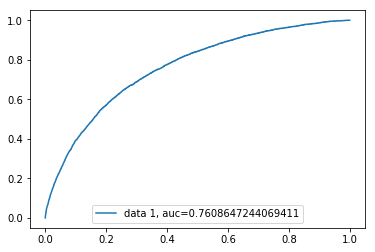

In [42]:
fpr, tpr, _ = metrics.roc_curve(y_test, proba)
auc = metrics.roc_auc_score(y_test, proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=8)
plt.show()

We got good results with CatBosst. We can apply this algorithm on the whole train data set to fit the algorithm. Then make predictions on the test set.

# Predictions on Test Set with CatBoost Algorithm

In this section I applied CatBoost algorithm with parameters of 2000 iteration and 5 folds for cross validation. I made predictions on the test set and saved this probabilities for each client into a csv file. Submitting this csv file (submission_yagmur_rigo2.csv) to Kaggle, my score was 0.75399. The screenshot is provided in the attachments (Rapor.doc).

In [ ]:
import pandas as pd
import catboost as cat
from sklearn.preprocessing import LabelEncoder
import os
import pickle
from sklearn.metrics import roc_auc_score


directory = 'C:\\CreditRiskProject\\Datasets'
train_set = pd.read_csv(directory+ '\\train_set_final.csv', index_col=0)
test_set = pd.read_csv(directory+ '\\test_set_final.csv', index_col=0)


#Remove Unnecessary colums
def removenonuniquecol(dataset):
    dropcols = [col for col in dataset.columns if dataset[col].nunique(dropna=True)==1]
    print ('Removing columns: ',dropcols)
    dataset.drop(dropcols,axis= 1,inplace= True,errors= 'ignore')
    return dropcols

#For label encoding
def labelencoder(dataset):
    objectlist = dataset.select_dtypes(include=['object']).copy()
    cat_col = [col for col in dataset.columns if col in objectlist]
    for col in cat_col:
        print("Encoding ",col)
        lbl = LabelEncoder()
        dataset[col].fillna(-999)
        lbl.fit(list(dataset[col].values.astype('str')))
        dataset[col] = lbl.transform(list(dataset[col].values.astype('str')))
    return cat_col

#######################Trainset-Testset preperation#####################################################

def TrainPrep(Datasetname):
    removedCols = removenonuniquecol(Datasetname)
    Predictors = [col for col in Datasetname]
    Predictors = [col for col in Predictors if col not in removedCols]
    Predictors = [col for col in Predictors if col not in ['TARGET']]
    DfLabel = Datasetname['TARGET']
    encodedList = labelencoder(Datasetname)
    return Predictors,Datasetname, DfLabel, removedCols, encodedList


def TestPrep(Datasetname):
    encodedList = labelencoder(Datasetname)
    return Datasetname, encodedList



Predictors,Df_train, label_train, removedCols, encodedList = TrainPrep(train_set)
Df_test, encodedList_test = TestPrep(test_set)

#####################Training Classifier############################################################################


def catboosttrainer(X,y,features,initparam,modelname,modelpath,docpath,cvfold = 5):
    print ("searching for optimal iteration count...")
    trainpool = cat.Pool(X[features],y)
    cvresult = cat.cv(params= initparam, fold_count=cvfold, pool=trainpool,stratified = True)
    initparam['iterations'] = (len(cvresult)) - (initparam['od_wait']+1)   
    del initparam['od_wait'] 
    del initparam['od_type']
    print ("optimal iteration count is ", initparam['iterations'])
    print ("fitting model...")
    clf = cat.CatBoostClassifier(** initparam)
    clf.fit(trainpool)
    imp = clf.get_feature_importance(trainpool,fstr_type='FeatureImportance')
    dfimp = pd.DataFrame(imp,columns = ['CatBoostImportance'])
    dfimp.insert(0,column='Feature', value=features) 
    dfimp = dfimp.sort_values(['CatBoostImportance','Feature'], ascending= False)
    xlsxpath = os.path.join(docpath,modelname+".xlsx")
    dfimp.to_excel(xlsxpath)
    print ("pickling model...")
    picklepath = os.path.join(modelpath,modelname)
    with open(picklepath,'wb') as fout:
        pickle.dump(clf, fout)
    return cvresult,clf,initparam,dfimp



modelpath = 'C:\\CreditRiskProject'
docpath = 'C:\\CreditRiskProject'
CatBoostParam = { 'iterations': 2000, 'od_type': 'Iter', 'od_wait': 100,'loss_function': 'Logloss','eval_metric': 'AUC', "random_seed" : 123}

cvresult,clf,initparam,dfimp = catboosttrainer(Df_train,label_train,Predictors,CatBoostParam,'CBmodel_big',modelpath,docpath,cvfold = 5)

predictions = clf.predict_proba(Df_test)[:,1]


#READING SAMPLE SUBMISSION FILE

sample = pd.read_csv(directory+'\\sample_submission.csv')
sample['TARGET']=predictions
#CREATING SUMBISSION FILE
sample.to_csv(directory+ '\\submission_yagmur_rigo2.csv',index=False)

# Predictions on Test Set with Random Forest Algorithm

In this section I applied Random Forest algorithm with parameters of 100 iterations. I made predictions on the test set and saved this probabilities for each client into a csv file. Submitting this csv file (submission_yagmur_rigo2_RandomForest.csv) to Kaggle, my score was 0.66598. The screenshot is provided in the attachments (Rapor.doc).

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

directory = 'C:\\CreditRiskProject\\Datasets'
train_set = pd.read_csv(directory+ '\\train_set_final.csv', index_col=0)
test_set = pd.read_csv(directory+ '\\test_set_final.csv', index_col=0)

#Remove Unnecessary colums
def removenonuniquecol(dataset):
    dropcols = [col for col in dataset.columns if dataset[col].nunique(dropna=True)==1]
    print ('Removing columns: ',dropcols)
    dataset.drop(dropcols,axis= 1,inplace= True,errors= 'ignore')
    return dropcols

#For label encoding
def labelencoder(dataset):
    objectlist = dataset.select_dtypes(include=['object']).copy()
    cat_col = [col for col in dataset.columns if col in objectlist]
    for col in cat_col:
        print("Encoding ",col)
        lbl = LabelEncoder()
        dataset[col].fillna(-999)
        lbl.fit(list(dataset[col].values.astype('str')))
        dataset[col] = lbl.transform(list(dataset[col].values.astype('str')))
    return cat_col

#######################Trainset-Testset preperation#####################################################

def TrainPrep(Datasetname):
    removedCols = removenonuniquecol(Datasetname)
    Predictors = [col for col in Datasetname]
    Predictors = [col for col in Predictors if col not in removedCols]
    Predictors = [col for col in Predictors if col not in ['TARGET']]
    DfLabel = Datasetname['TARGET']
    encodedList = labelencoder(Datasetname)
    return Predictors,Datasetname, DfLabel, removedCols, encodedList


def TestPrep(Datasetname):
    encodedList = labelencoder(Datasetname)
    return Datasetname, encodedList

#Prepare train and test sets for the model
Predictors,Df_train, label_train, removedCols, encodedList = TrainPrep(train_set)
Df_test, encodedList_test = TestPrep(test_set)

X_train = Df_train[Predictors]
Y_tarin = label_train
x_test = Df_test

#fill na values with the mean of the column
X_train = X_train.fillna(X_train.mean())

#Fit the RF model:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train,Y_tarin)

#Predict y_test
x_test = x_test.fillna(x_test.mean())
y_test = regressor.predict(x_test)

#READING SAMPLE SUBMISSION FILE
sample = pd.read_csv(directory+'\\sample_submission.csv')
sample['TARGET']=y_test
#CREATING SUMBISSION FILE
sample.to_csv(directory+ '\\submission_yagmur_rigo2_RandomForest.csv',index=False)
